In [373]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import re
from datetime import datetime

#from sklearn.impute import SimpleImputer
#from scipy import interpolate
from sklearn.preprocessing import LabelEncoder

from nltk import word_tokenize

pd.set_option('max_columns', None)
pd.set_option('max_rows', 1000)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

In [374]:
sns.set_context('notebook')

Load json Dataset

In [375]:
with open("/Users/anjalirajwade/Downloads/signals_all.json")as f:
    data = json.load(f)

In [376]:
df = pd.json_normalize(data, sep = "_")  # since json file is not flattened so we need to normalize it

In [377]:
#df.head(1000)

Clean data & EDA

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7258 entries, 0 to 7257
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            7258 non-null   object 
 1   app                7258 non-null   object 
 2   signalType         7258 non-null   object 
 3   product_id         4506 non-null   object 
 4   query_term         7258 non-null   object 
 5   _id_$oid           7258 non-null   object 
 6   createdDate_$date  7258 non-null   object 
 7   seenfor            2358 non-null   float64
dtypes: float64(1), object(7)
memory usage: 453.8+ KB


In [379]:
#df.describe(include='all',datetime_is_numeric=True)

change date format to datetime from object

In [380]:
df['createdDate_$date']= pd.to_datetime(df['createdDate_$date']) 
df['createdDate_$date'] = df['createdDate_$date'].values.astype(dtype='datetime64[ms]')

extract features from query term

In [381]:
df['query_term_s']  = df['query_term'].apply(lambda x : re.split(':',x)) # split using :

In [382]:
df['query_term_2'] = df.query_term_s.apply(lambda x : x[-1] ) # get the second query

In [383]:
def que1(x):      # def a user def function to clean query_s 
    if '&' not in x :
        return 'None'
    else:
        return re.split('&',x)

In [384]:
df['query_term_s'] = df.query_term_s.apply(lambda x : que1(x[0]))  

In [385]:
def que1_d(x):     # def a user def function to clean query_s and get query_1
    if type(x) == list:
        return x[0]
    else:
        return 'None'

In [386]:
df['query_term_1'] = df.query_term_s.apply(lambda x : que1_d(x) ) # get the first query

In [387]:
df = df.drop(['query_term_s','_id_$oid'],axis=1) # drop values not needed

 clean product_id 

In [388]:
df['product_id'] = df.product_id.fillna(method='ffill') # fill missing 

In [389]:
le =  LabelEncoder()
df['product_id'] = le.fit_transform(df['product_id'])

Create a new feature

In [430]:
df["UserFreq"] = (df.groupby("user_id")["user_id"].transform("count")/df.user_id.count()) 
# calculate the frequency with which each user_id occurs in the dataset

In [453]:
df['day'] = df['createdDate_$date'].dt.day_name()
df["day_freq"] = (df.groupby("day")["day"].transform("count")/df.day.count()) 


In [455]:
df.head(5)

,user_id,app,signalType,product_id,query_term,createdDate_$date,seenfor,query_term_2,query_term_1,UserFreq,day,day_freq
0,user5,NewCommerceSolr,view,326,shirts&param=L2Category:women,2019-06-11 13:55:49.504,NaN,women,shirts,0.099752,Tuesday,0.177046
1,user5,NewCommerceSolr,view,445,earrings&param=L2Category:jewelry,2019-06-11 13:55:39.180,NaN,jewelry,earrings,0.099752,Tuesday,0.177046
2,user5,NewCommerceSolr,view,229,earrings&param=L2Category:jewelry,2019-06-11 13:54:57.109,NaN,jewelry,earrings,0.099752,Tuesday,0.177046
3,user5,NewCommerceSolr,view,710,shirts&param=L2Category:women,2019-06-11 14:08:54.483,NaN,women,shirts,0.099752,Tuesday,0.177046
4,user5,NewCommerceSolr,view,153,shirts&param=L2Category:women,2019-06-11 14:12:19.973,NaN,women,shirts,0.099752,Tuesday,0.177046


<Figure size 1440x1440 with 0 Axes>

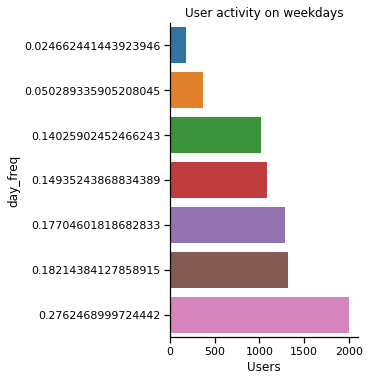

In [468]:
plt.figure(figsize=(20,20))
sns.catplot(x = 'day_freq' , kind = 'count' , data = df , col = 'user_id') # week starts form monday
plt.xlabel('Users')
plt.title('User activity on weekdays')
plt.show()

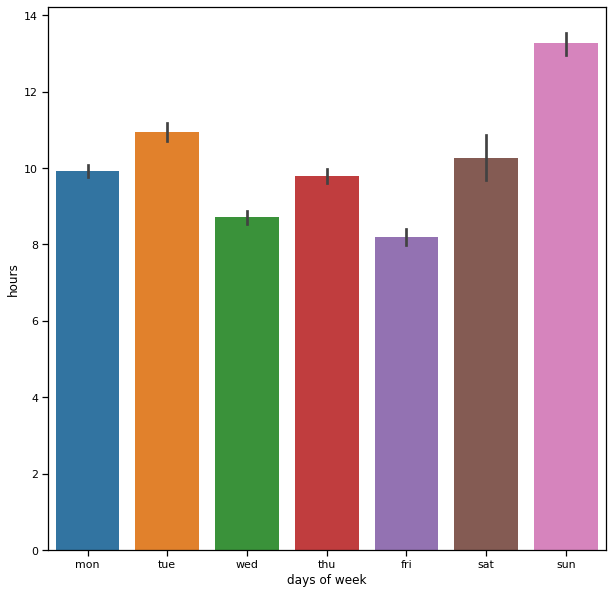

In [441]:
plt.figure(figsize=(10,10))
ax = sns.barplot(x = df['createdDate_$date'].dt.weekday , y = df['createdDate_$date'].dt.hour )
ax.set_xticklabels(['mon','tue','wed','thu','fri','sat','sun'])
ax.set_xlabel('days of week')
ax.set_ylabel('hours')
plt.show()

In [411]:
df.columns

Index(['user_id', 'app', 'signalType', 'product_id', 'query_term',
       'createdDate_$date', 'seenfor', 'query_term_2', 'query_term_1'],
      dtype='object')

In [235]:
#plt.figure(figsize=(10,10))
#sns.catplot(x = 'user_id', hue = 'day', data = df)
#plt.show()

In [236]:
#plt.figure(figsize=(15,10))
#ax = sns.countplot(df['new_date'].dt.month , hue = df['new_date'].dt.day_name()) # since primarily all data collected was during office hours
#plt.legend(['mon','tue','wed','thu','fri','sat','sun'])
#ax.set_xlabel('months')
#plt.show()

In [237]:
#plt.figure(figsize=(20, 300), dpi=50)
#ax = sns.countplot(y = df.query_term_2[df['signalType'] == 'query'])
#plt.tick_params(axis='x', labelsize=10)
#plt.tick_params(axis='y', labelsize=20)
#plt.legend(loc=1)

In [238]:
#plt.figure(figsize=(20, 50), dpi=50)
#ax = sns.countplot(y = df.query_term_1[df['query_term_1'] != 'None'] )
#plt.tick_params(axis='x', labelsize=20)
#plt.tick_params(axis='y', labelsize=20)

In [239]:
#plt.figure(figsize=(10,10))
#ax = sns.countplot(x = df1.seenfor_1 )
#ax.set_xticklabels(['0 sec viewed', 'viewed more than 0 sec'])


In [240]:
#corremat = df1.corr()      # plot heatmap . convert values 
#plt.figure(figsize=(10,10))
#g= sns.heatmap(df1.corr(),annot=True,cmap='viridis',linewidths=.5)

In [241]:
#fig = plt.figure(figsize=(20, 75), dpi=50)
#sns.countplot(y = df1.query_term., hue=df3.seenfor_1)
#plt.tick_params(axis='x', labelsize=15)
#plt.tick_params(axis='y', labelsize=12)
#plt.legend(loc=1)

In [242]:
df1 = df.dropna(subset=['seenfor']) # data frame for dealing with seenfor data . remove nan values
df1 = df1.reset_index(drop=True)
df1.shape

(2358, 10)

In [228]:
df['seenfor'] = df['seenfor'].apply(lambda x : round(x/1000,1) ) #convert the given data from microsec to sec 

In [243]:
#df1.describe(include='all')

In [244]:
df2 = df1[df1['seenfor'] < 150 ]  # dealing with under 150 sec i.e 
df2.shape

(2291, 10)

In [245]:
df1[df1['seenfor'] < 30 ].shape

(2155, 10)

In [246]:
df2 = df2[df2['seenfor'] != 0 ]
df2 = df2.reset_index(drop=True)
df2.shape

(491, 10)

In [247]:
#plt.figure(figsize=(10,10))
#sns.relplot(y = df2.seenfor[df2['seenfor']<50]  , x = df2.index[df2['seenfor']<50],kind='scatter', hue = df2['createdDate_$date'].dt.weekday[df2['seenfor']<50],palette = 'Accent' )
#plt.ylabel('in seconds')
#plt.xlabel('index')
#plt.show()

In [248]:
def func_sf2 (x):
    if x <= 1: return " 1 sec viewed"
    elif x <= 2 : return " 2 sec viewed"
    elif x <= 3 : return " 3 sec viewed"
    elif x <= 4 : return " 4 sec viewed"
    elif x <= 5 : return " 5 sec viewed"
    elif x <= 6 : return " 6 sec viewed"
    elif x <= 7 : return " 7 sec viewed"
    elif x <= 8 : return " 8 sec viewed"
    elif x <= 9 : return " 9 sec viewed"
    elif x <= 10 : return " 10 sec viewed"
    else: return "more than that (anamoly)"
    
    

In [249]:
df2['seenfor_1'] = df2['seenfor'].apply(func_sf2)

In [287]:
#plt.figure(figsize=(10,10))
#ax = sns.countplot(x = df2.seenfor_1[df2['seenfor']<=2])

In [251]:
s1 = ['relatedProducts','UserRecommend','Promotions','FeaturedProduct','BestSellers','NewArrival',
      'Recommend','ItemABRecommendation']
df3 = df[df['query_term_2'] == s1[0]]
for i in range(len(s1)) :
    df3_1 = df[df['query_term_2'] == s1[i]]
    df3 = df3.append(df3_1)

In [252]:
df3.describe(include='all')

<ipython-input-252-bb9d08cd69bc>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df3.describe(include='all')


,user_id,app,signalType,product_id,query_term,createdDate_$date,seenfor,query_term_2,query_term_1,day
count,4246,4246,4246,4246,4246,4246,2264.000000,4246,4246,4246
unique,8,1,5,480,8,2005,NaN,8,1,7
top,sachindes,NewCommerceSolr,view,0042bd96f5792677f1db0eb222972752,relatedProducts,2021-03-26 04:03:19.998000,NaN,relatedProducts,None,Friday
freq,2846,4246,3434,304,2238,229,NaN,2238,4246,1080
first,NaN,NaN,NaN,NaN,NaN,2020-11-30 05:30:47.500000,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2021-05-29 05:56:44.373000,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,186.855345,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,1698.762548,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN


<Figure size 720x720 with 0 Axes>

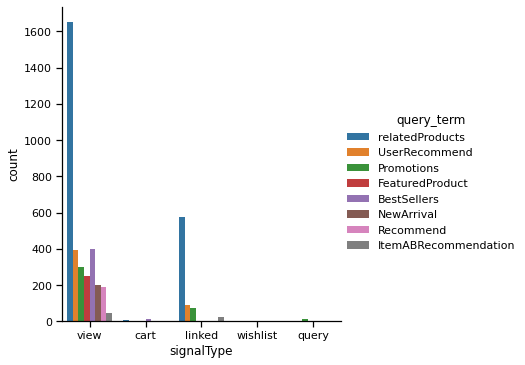

In [253]:
plt.figure(figsize=(10,10))
sns.catplot(x = 'signalType', data = df3 ,kind = 'count' , hue = 'query_term' , )
plt.show()

In [254]:
df3.signalType.isna().sum()

0

In [255]:
sns.catplot?

In [256]:
s1 = ['relatedProducts','UserRecommend','Promotions','FeaturedProduct','BestSellers','NewArrival',
      'Recommend','ItemABRecommendation']
#df4 = df2[df2['query_term_2'] == s1[0]]
for i in range(len(s1)) :
    df4_1 = df2[df2['query_term_2'] == s1[i]]
    df4 = df4.append(df4_1)

In [257]:
df4.head(3)

,user_id,app,signalType,product_id,query_term,createdDate_$date,seenfor,query_term_2,query_term_1,seenfor_1,day
0,sachindes,NewCommerceSolr,view,4716e8dfbfa60238573f92ebc4ea7a41,relatedProducts,2021-03-26 08:39:46.188,3.3,relatedProducts,None,15 sec viewed,NaN
1,sachindes,NewCommerceSolr,view,a171c2ceb3929a3672fe1899bd85bd56,relatedProducts,2021-03-26 08:39:46.188,22.4,relatedProducts,None,41.4 min viewed,NaN
2,sachindes,NewCommerceSolr,view,1f04489457d060159339b8d7ccf83fea,relatedProducts,2021-03-26 08:39:46.188,66.3,relatedProducts,None,more than that (anamoly),NaN


In [258]:
 df4.describe(include='all')

<ipython-input-258-6487b3ad519b>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df4.describe(include='all')


,user_id,app,signalType,product_id,query_term,createdDate_$date,seenfor,query_term_2,query_term_1,seenfor_1,day
count,1037,1037,1037,1037,1037,1037,1037.000000,1037,1037,1037,432
unique,4,1,1,238,8,290,NaN,8,1,14,7
top,sachindes,NewCommerceSolr,view,fe6ae3431256fdfc99117bf11f8b4278,relatedProducts,2021-04-30 06:44:53.648000,NaN,relatedProducts,None,more than that (anamoly),Friday
freq,881,1037,1037,52,519,64,NaN,519,1037,358,118
first,NaN,NaN,NaN,NaN,NaN,2021-03-26 08:39:46.188000,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2021-05-29 05:56:44.373000,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,26.563067,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,34.154433,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.100000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.100000,NaN,NaN,NaN,NaN


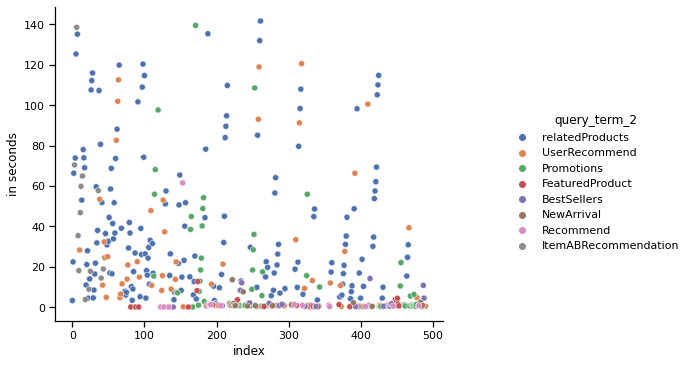

In [259]:
ax = sns.relplot(y = df4.seenfor  , x = df4.index ,kind='scatter', hue = df4.query_term_2 , palette = 'deep' )
plt.ylabel('in seconds')
ax.fig.set_figwidth(10)
ax.fig.set_figheight(5)
plt.xlabel('index')
plt.show()

In [260]:
def quartiles(x):
    if x <= 1.4: return " 1.4 sec viewed"
    elif x <= 14.9 : return " 15 sec viewed"
    elif x <= 41.4 : return " 41.4 min viewed"
    else: return "more than that (anamoly)"

In [261]:
df4['seenfor_1'] = df4['seenfor'].apply(quartiles)

Text(0.5, 0, 'in seconds')

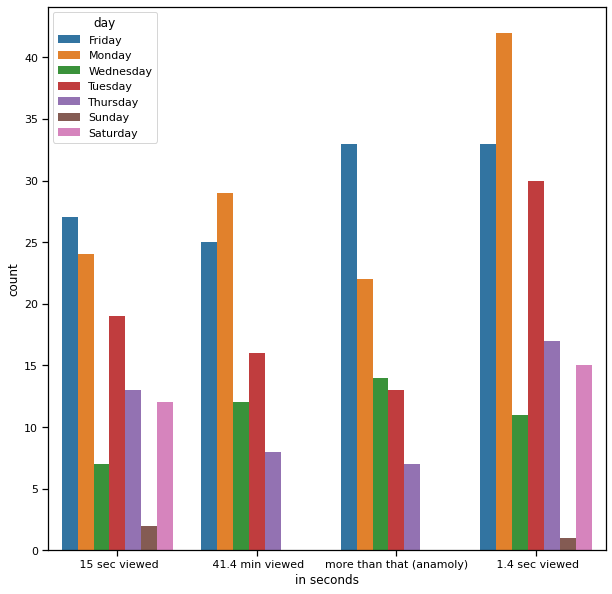

In [268]:
plt.figure(figsize=(10,10))
sns.countplot(x = df4.seenfor_1, hue = df4.day) # week starts form monday
plt.xlabel('in seconds')

Text(0.5, 0, 'in seconds')

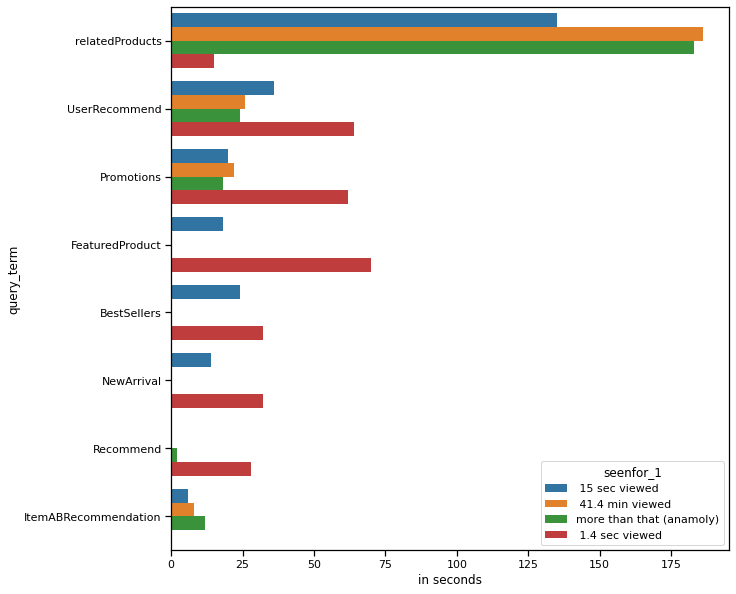

In [272]:
plt.figure(figsize=(10,10))
sns.countplot(hue = df4.seenfor_1, y = df4.query_term)
plt.xlabel('in seconds')

<Figure size 2160x2160 with 0 Axes>

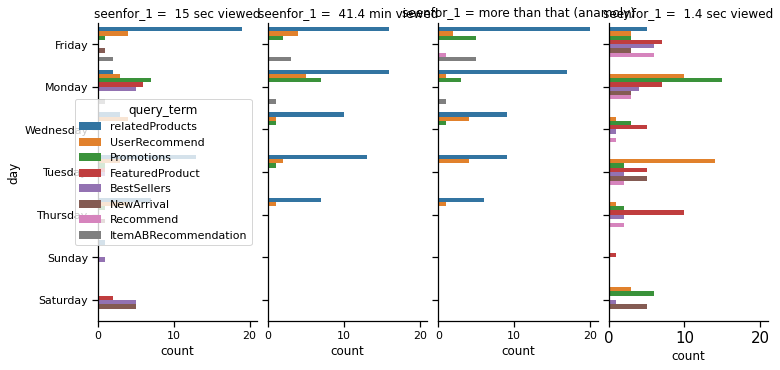

In [285]:
plt.figure(figsize=(30,30))
ax = sns.catplot(y = 'day', data = df4 ,kind = 'count' , hue = 'query_term' , col = 'seenfor_1' ,legend_out=False)
ax.fig.set_figwidth(10)
ax.fig.set_figheight(5)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
#plt.legend(loc=1)
plt.show()

In [286]:
sns.catplot?